In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, roc_curve, auc

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

In [8]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

maxlen = 100
x_train = pad_sequences(x_train, maxlen=maxlen) 
x_test = pad_sequences(x_test, maxlen=maxlen)   

In [9]:
def build_model(hp):
    
    model = Sequential()  
    
  
    model.add(Embedding(input_dim=10000,
                        output_dim=hp.Int("embedding_output", min_value=32, max_value=128, step=32),  
                        input_length=maxlen))
    
    
    model.add(SimpleRNN(units=hp.Int("rnn_units", min_value=32, max_value=128, step=32))) 
    
   
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))  
    
    
    model.add(Dense(1, activation="sigmoid"))
    

    model.compile(optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),  
                  loss="binary_crossentropy",  
                  metrics=["accuracy", "AUC"])  
    
    return model

In [10]:
tuner = RandomSearch(
    build_model,  
    objective="val_loss",  
    max_trials=10,  
    executions_per_trial=1,  
    directory="rnn_tuner_directory",  
    project_name="imdb_rnn"  
)


early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


tuner.search(x_train, y_train,
             epochs=2,
             validation_split=0.2, 
             callbacks=[early_stopping])

Trial 10 Complete [00h 02m 22s]
val_loss: 0.6023427248001099

Best val_loss So Far: 0.38315123319625854
Total elapsed time: 00h 15m 09s


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

loss, accuracy, auc_score = best_model.evaluate(x_test, y_test) 
print(f"Test loss: {loss}, test accuracy: {accuracy:.3f}, test auc: {auc_score:.3f}")

782/782 [==============================] - 19s 17ms/step - loss: 0.3751 - accuracy: 0.8393 - auc: 0.9172
Test loss: 0.3750878572463989, test accuracy: 0.839, test auc: 0.917


782/782 [==============================] - 14s 16ms/step
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     12500
           1       0.81      0.89      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



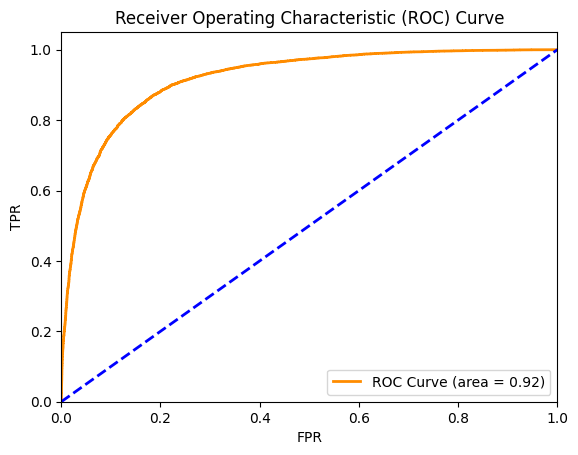

In [12]:
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32") 

print(classification_report(y_test, y_pred))  

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  

roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC Curve (area = %0.2f)" % roc_auc)  # ROC eğrisi
plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")  # rastgele tahmin çizgisi
plt.xlim([0, 1])
plt.ylim([0, 1.05]) 
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()